In [1]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(512)
environ['n_epochs']= '1000'
environ['batch_norm']= 'True'
environ['loss_func']='MAPE'
environ['layers'] = '120 80 30'
environ['dropouts'] = '0.2'+' 0.3'*4
environ['log'] = 'False'
environ['weight_decay'] = '0.00'
environ['cuda_device'] ='cuda:1'
environ['dataset'] = 'data/blur2d.pkl'

%run utils.ipynb

In [2]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

In [3]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion],
               callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                                        monitor='mape_criterion', min_delta=0.1, patience=500)])

if optimizer == 'SGD':
    l.opt_func = optim.SGD 
    

In [4]:
l = l.load(f"training_tuning")

In [10]:
l.lr_find()

ZeroDivisionError: division by zero

In [ ]:
l.recorder.plot()

In [4]:
lr = 1e-03

In [5]:
l.fit_one_cycle(100, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion


/home/mohammed/anaconda3/lib/python3.6/site-packages/fastprogress/fastprogress.py:96: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/home/mohammed/anaconda3/lib/python3.6/site-packages/fastprogress/fastprogress.py:96: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


RuntimeError: expected a non-empty list of Tensors

In [ ]:
l.recorder.plot_losses()

In [9]:
l.save(f"training_tuning")

In [5]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)
test_df = get_results_df(test_dl, l.model)

In [6]:
df = pd.concat([val_df, test_df])

In [8]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.413576,0.469633,0.121196,27.027849
std,0.472750,0.748854,0.377212,32.709480
min,0.014930,0.011766,0.000011,0.004518
25%,0.124545,0.119905,0.014898,8.726650
50%,0.297695,0.299996,0.046940,18.616159
75%,0.548960,0.609846,0.114020,32.135881
max,4.243530,11.273418,7.439478,426.500885


/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


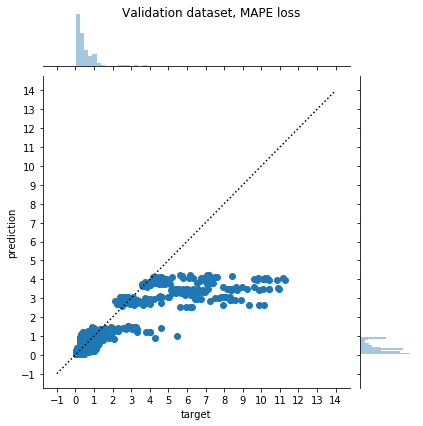

In [8]:
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")

In [56]:
bins = [10, 50,  80, 90]

counts = [df[(100-df.APE) >= thresh].APE.count() for thresh in bins]

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

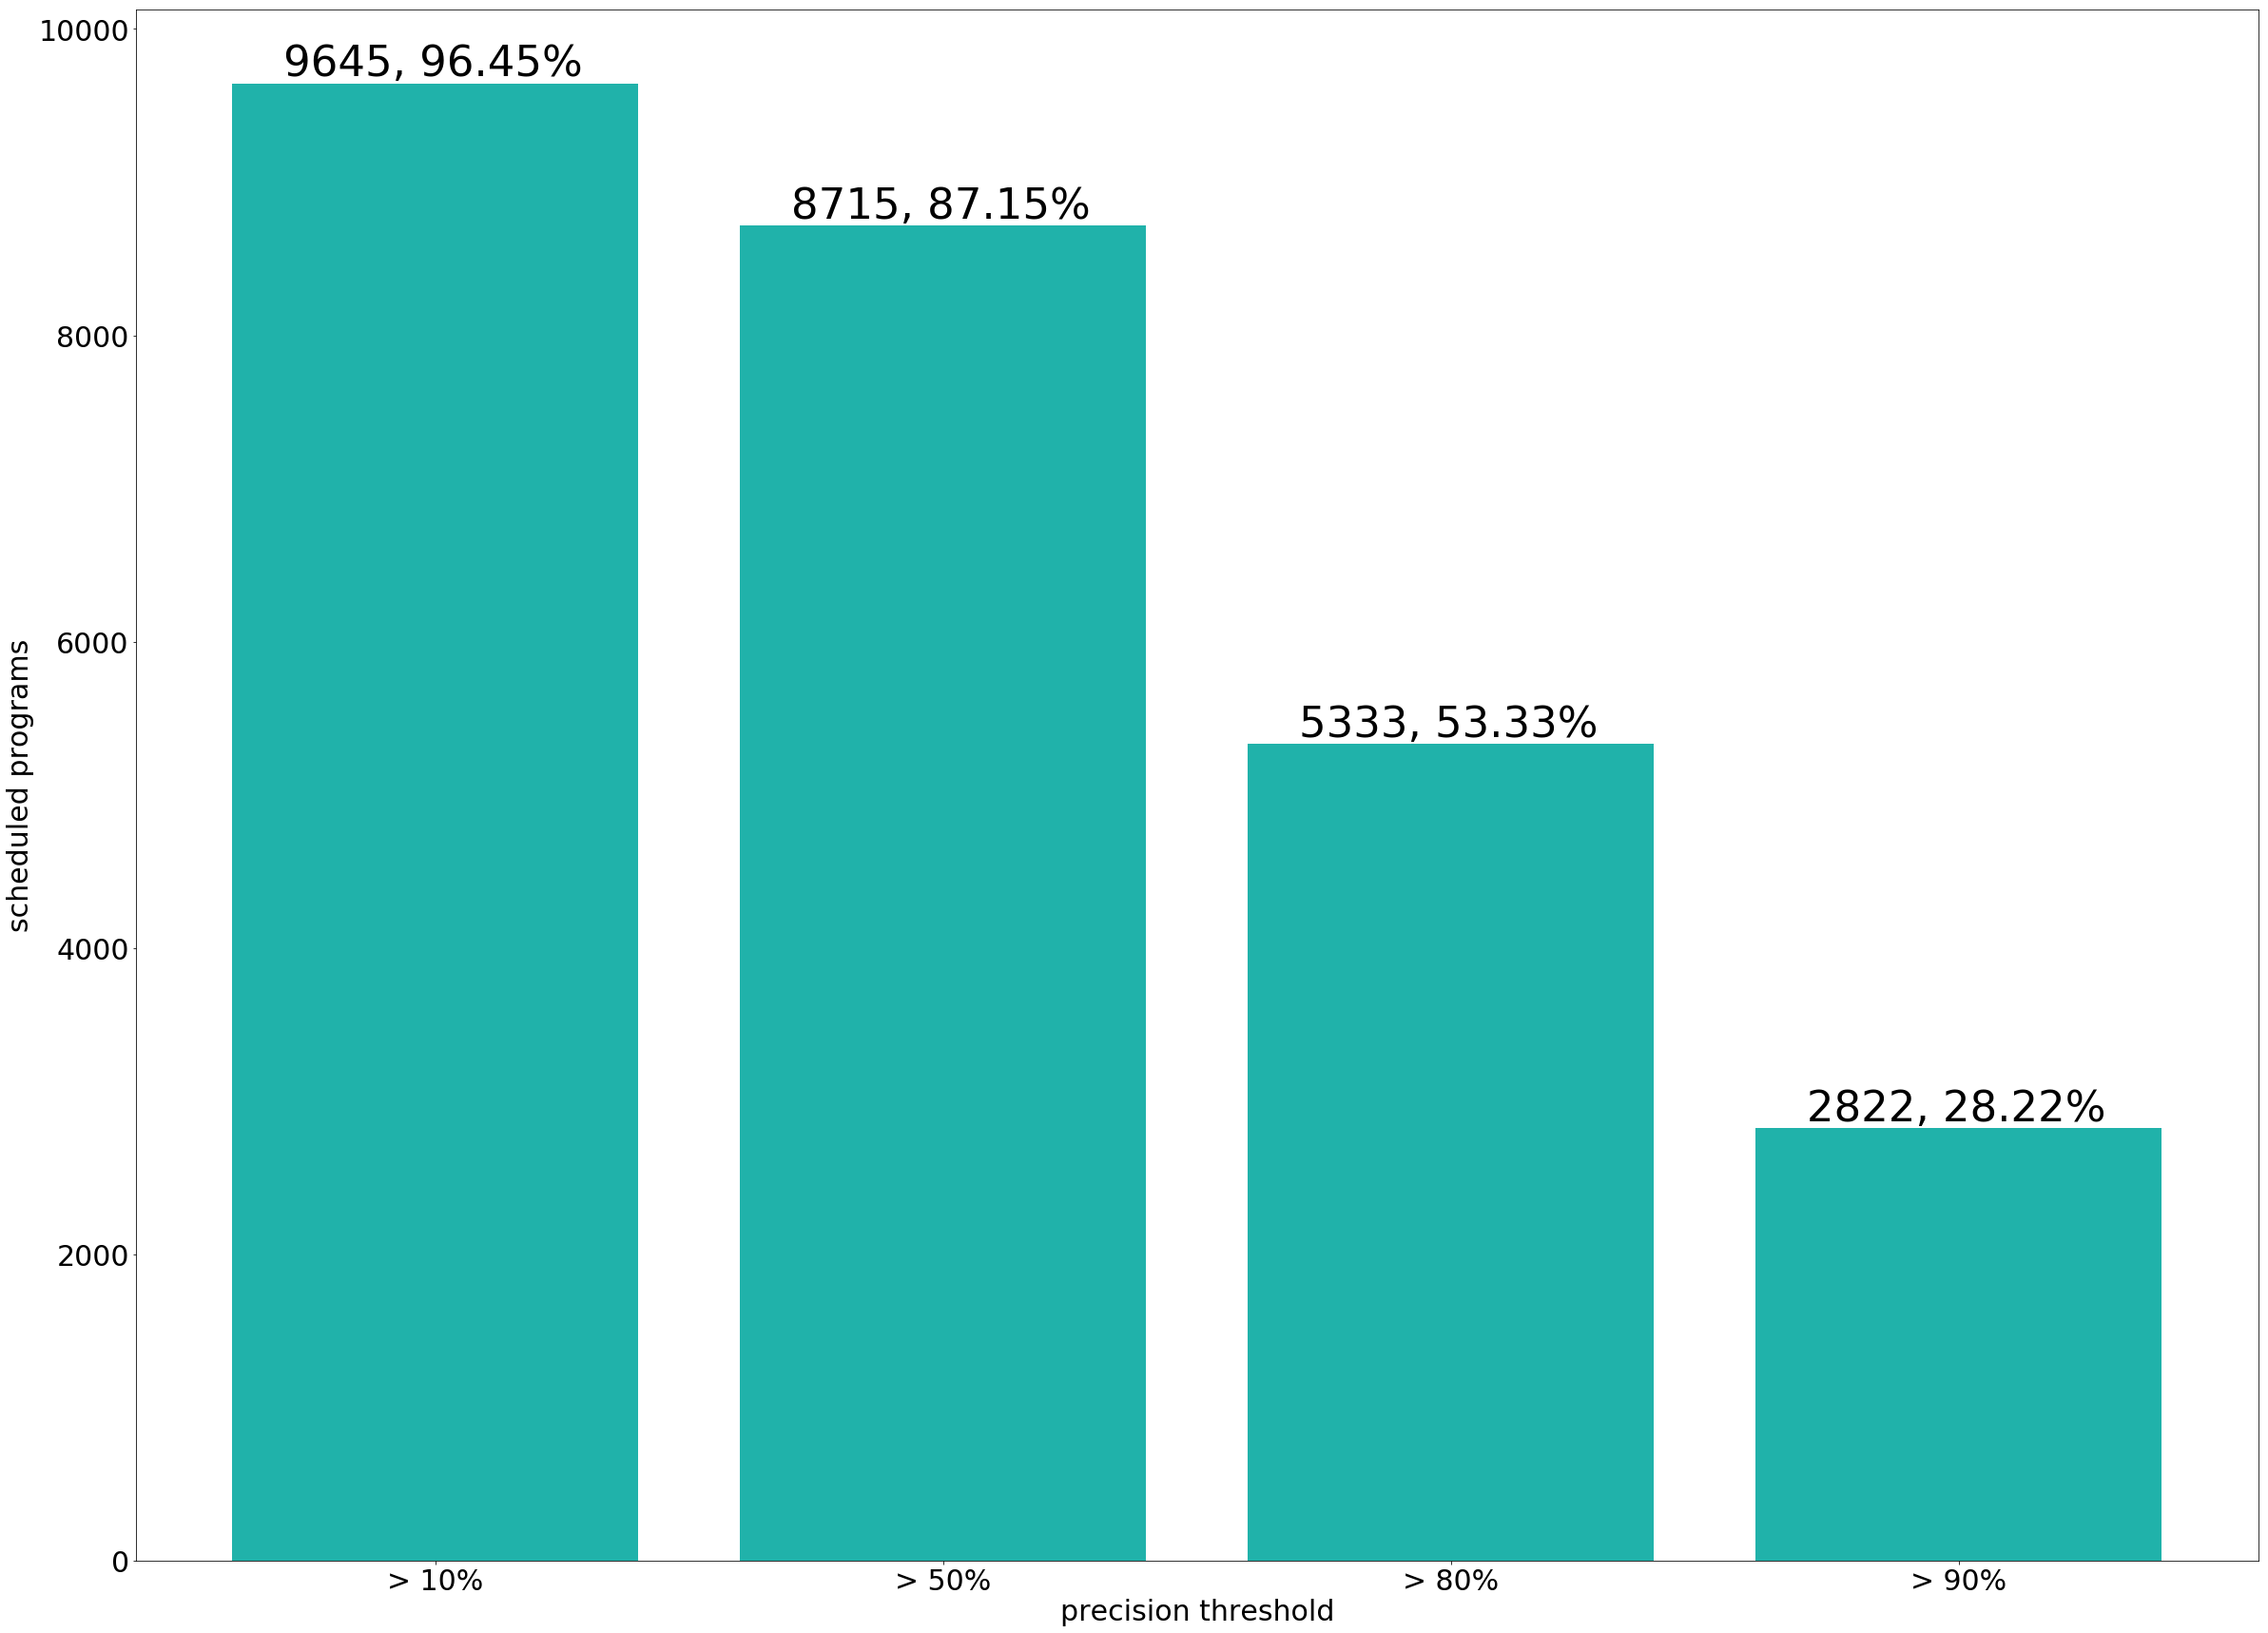

In [63]:
import pylab

pylab.bar(range(len(bins)), counts, color='lightseagreen')
pylab.xticks(ticks=range(len(bins)), labels=("> "+ str(thresh)+"%" for thresh in bins))

for i in range(len(counts)):
    plt.text(x = i-0.3 , y = counts[i]+50, 
             s = str(counts[i]) + ', ' + str(counts[i]/100) + '%', size=45)

pylab.xlabel('precision threshold', fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('scheduled programs', fontsize=30)
plt.xticks(fontsize=30)




In [15]:
df = val_df

In [18]:
df_ = df.sort_values(by=["target"])

df_['x'] = range(len(df_))

In [32]:
plt.rcParams['figure.figsize'] = [40, 30]

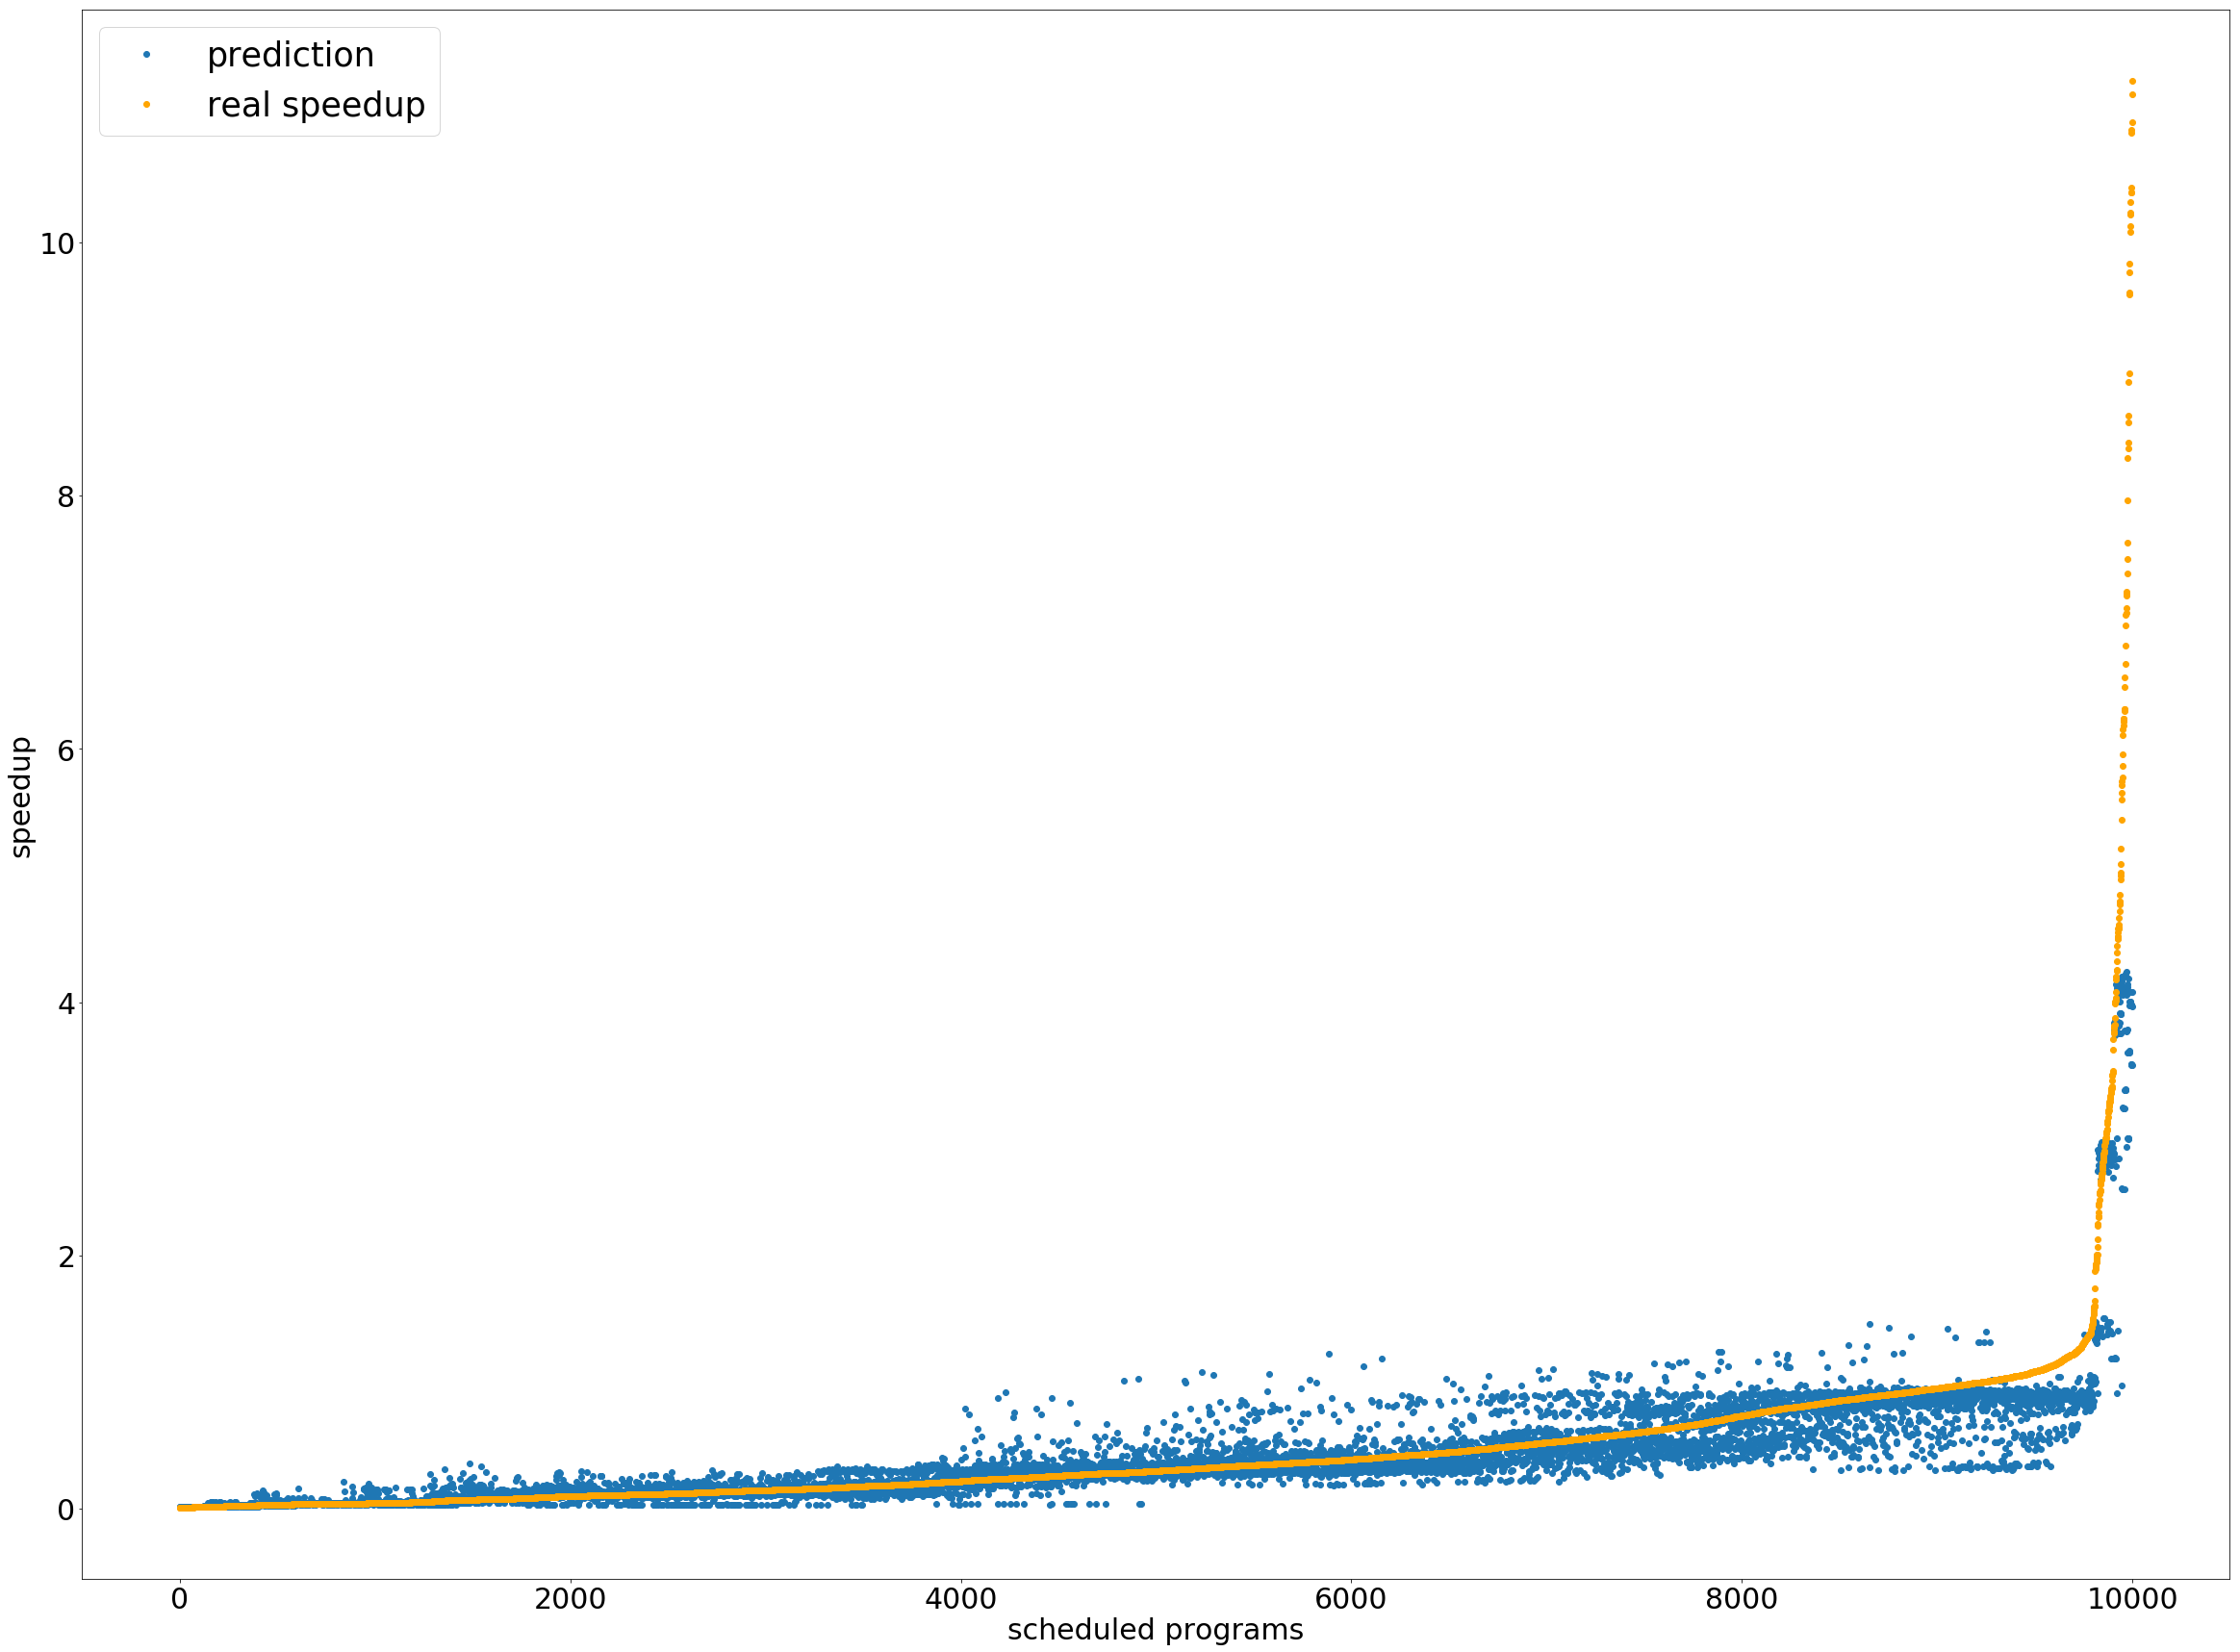

In [19]:
plt.plot('x', 'prediction', 'o',label='prediction',  data=df_)

plt.plot('x', 'target',  'o', color='orange', label='real speedup', data=df_)


plt.ylabel('speedup', fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('scheduled programs', fontsize=30)
plt.xticks(fontsize=30)
plt.legend(prop={"size": 35}, title_fontsize=30)


In [172]:
df = pd.concat([val_df,test_df], ignore_index=True)

In [6]:
df = val_df

In [7]:
df1 = df[:][['prediction','target', 'name']]

In [58]:
tmp_df = df1[df1.name == 'function382'].sort_values(by=["prediction"], ascending=False)

In [8]:
def evaluation_df(df1, n=1):
    eval_df = pd.DataFrame(columns=['performance', 'achieved_speedup', 'max_speedup', 'schedules_count', 'ranking'])

    for prog in set(df1.name):
        tmp_df = df1[df1.name == prog].sort_values(by=["prediction"], ascending=False)
        
        speedup = tmp_df.iloc[list(range(n))].target.max()

        perf = speedup / tmp_df.target.max()
        abs_diff =  tmp_df.target.max() - speedup

        
        speedups = sorted(tmp_df.target, reverse=True)
        
        rank = speedups.index(speedup) + 1
        

        new = pd.DataFrame()
        new['achieved_speedup'] = [speedup]
        new['performance'] = [perf]
        new['max_speedup'] = [tmp_df.target.max()]
        new['schedules_count'] = [len(tmp_df.target)]
        new['ranking'] = rank
 
        eval_df = pd.concat([eval_df, new],
                   ignore_index=True)         
    
    
   
    return eval_df





In [21]:
eval_df = evaluation_df(df1, n=1)

/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [26]:
eval_df.performance.mean()

0.8388058332835927

In [25]:
eval_df

,achieved_speedup,max_speedup,performance,ranking,schedules_count
0,7.211255,8.414969,0.856956,4,80
1,0.896169,1.000000,0.896169,35,532
2,0.927371,1.116073,0.830923,41,812
3,4.251027,7.242253,0.586976,5,80
4,1.373537,1.497731,0.917079,5,736
5,1.000000,1.060186,0.943231,11,1388
6,0.985381,1.347270,0.731391,86,736
7,1.006172,1.532539,0.656539,282,1384
8,0.864287,1.095596,0.788874,22,520
9,1.019130,1.170114,0.870967,26,736


In [11]:
eval_df = evaluation_df(df1, n=3)
eval_df

/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,achieved_speedup,max_speedup,performance,ranking,schedules_count
0,7.211255,8.414969,0.856956,4,80
1,0.921409,1.000000,0.921409,16,532
2,1.000000,1.116073,0.895998,17,812
3,4.251027,7.242253,0.586976,5,80
4,1.373537,1.497731,0.917079,5,736
5,1.000000,1.060186,0.943231,11,1388
6,0.985381,1.347270,0.731391,86,736
7,1.280553,1.532539,0.835576,42,1384
8,0.882452,1.095596,0.805453,18,520
9,1.068108,1.170114,0.912824,7,736


In [12]:
eval_df = evaluation_df(df1, n=5)
eval_df

/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,achieved_speedup,max_speedup,performance,ranking,schedules_count
0,8.414969,8.414969,1.000000,1,80
1,0.921409,1.000000,0.921409,16,532
2,1.086396,1.116073,0.973409,3,812
3,4.251027,7.242253,0.586976,5,80
4,1.373537,1.497731,0.917079,5,736
5,1.000000,1.060186,0.943231,11,1388
6,0.985381,1.347270,0.731391,86,736
7,1.280553,1.532539,0.835576,42,1384
8,0.882452,1.095596,0.805453,18,520
9,1.118755,1.170114,0.956108,3,736


In [10]:
eval_df = evaluation_df(df, n=12)
eval_df

/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,achieved_speedup,max_speedup,performance,ranking,schedules_count
0,1.373537,1.497731,0.917079,5,736
1,1.054888,1.347270,0.782982,50,736
2,1.132885,1.132885,1.000000,1,152
3,7.242253,7.242253,1.000000,1,80
4,1.000000,1.124060,0.889632,24,340
5,0.915675,1.095596,0.835778,16,520
6,1.324832,1.532539,0.864469,28,1384
7,11.273418,11.273418,1.000000,1,56
8,8.414969,8.414969,1.000000,1,80
9,3.445319,3.625341,0.950343,2,80


In [37]:
perfs=[]
for n in range(1, 26):
    tmp = evaluation_df(df1, n=n)
    perfs.append(tmp.performance.mean()*100)
    


/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text xticklabel objects>)

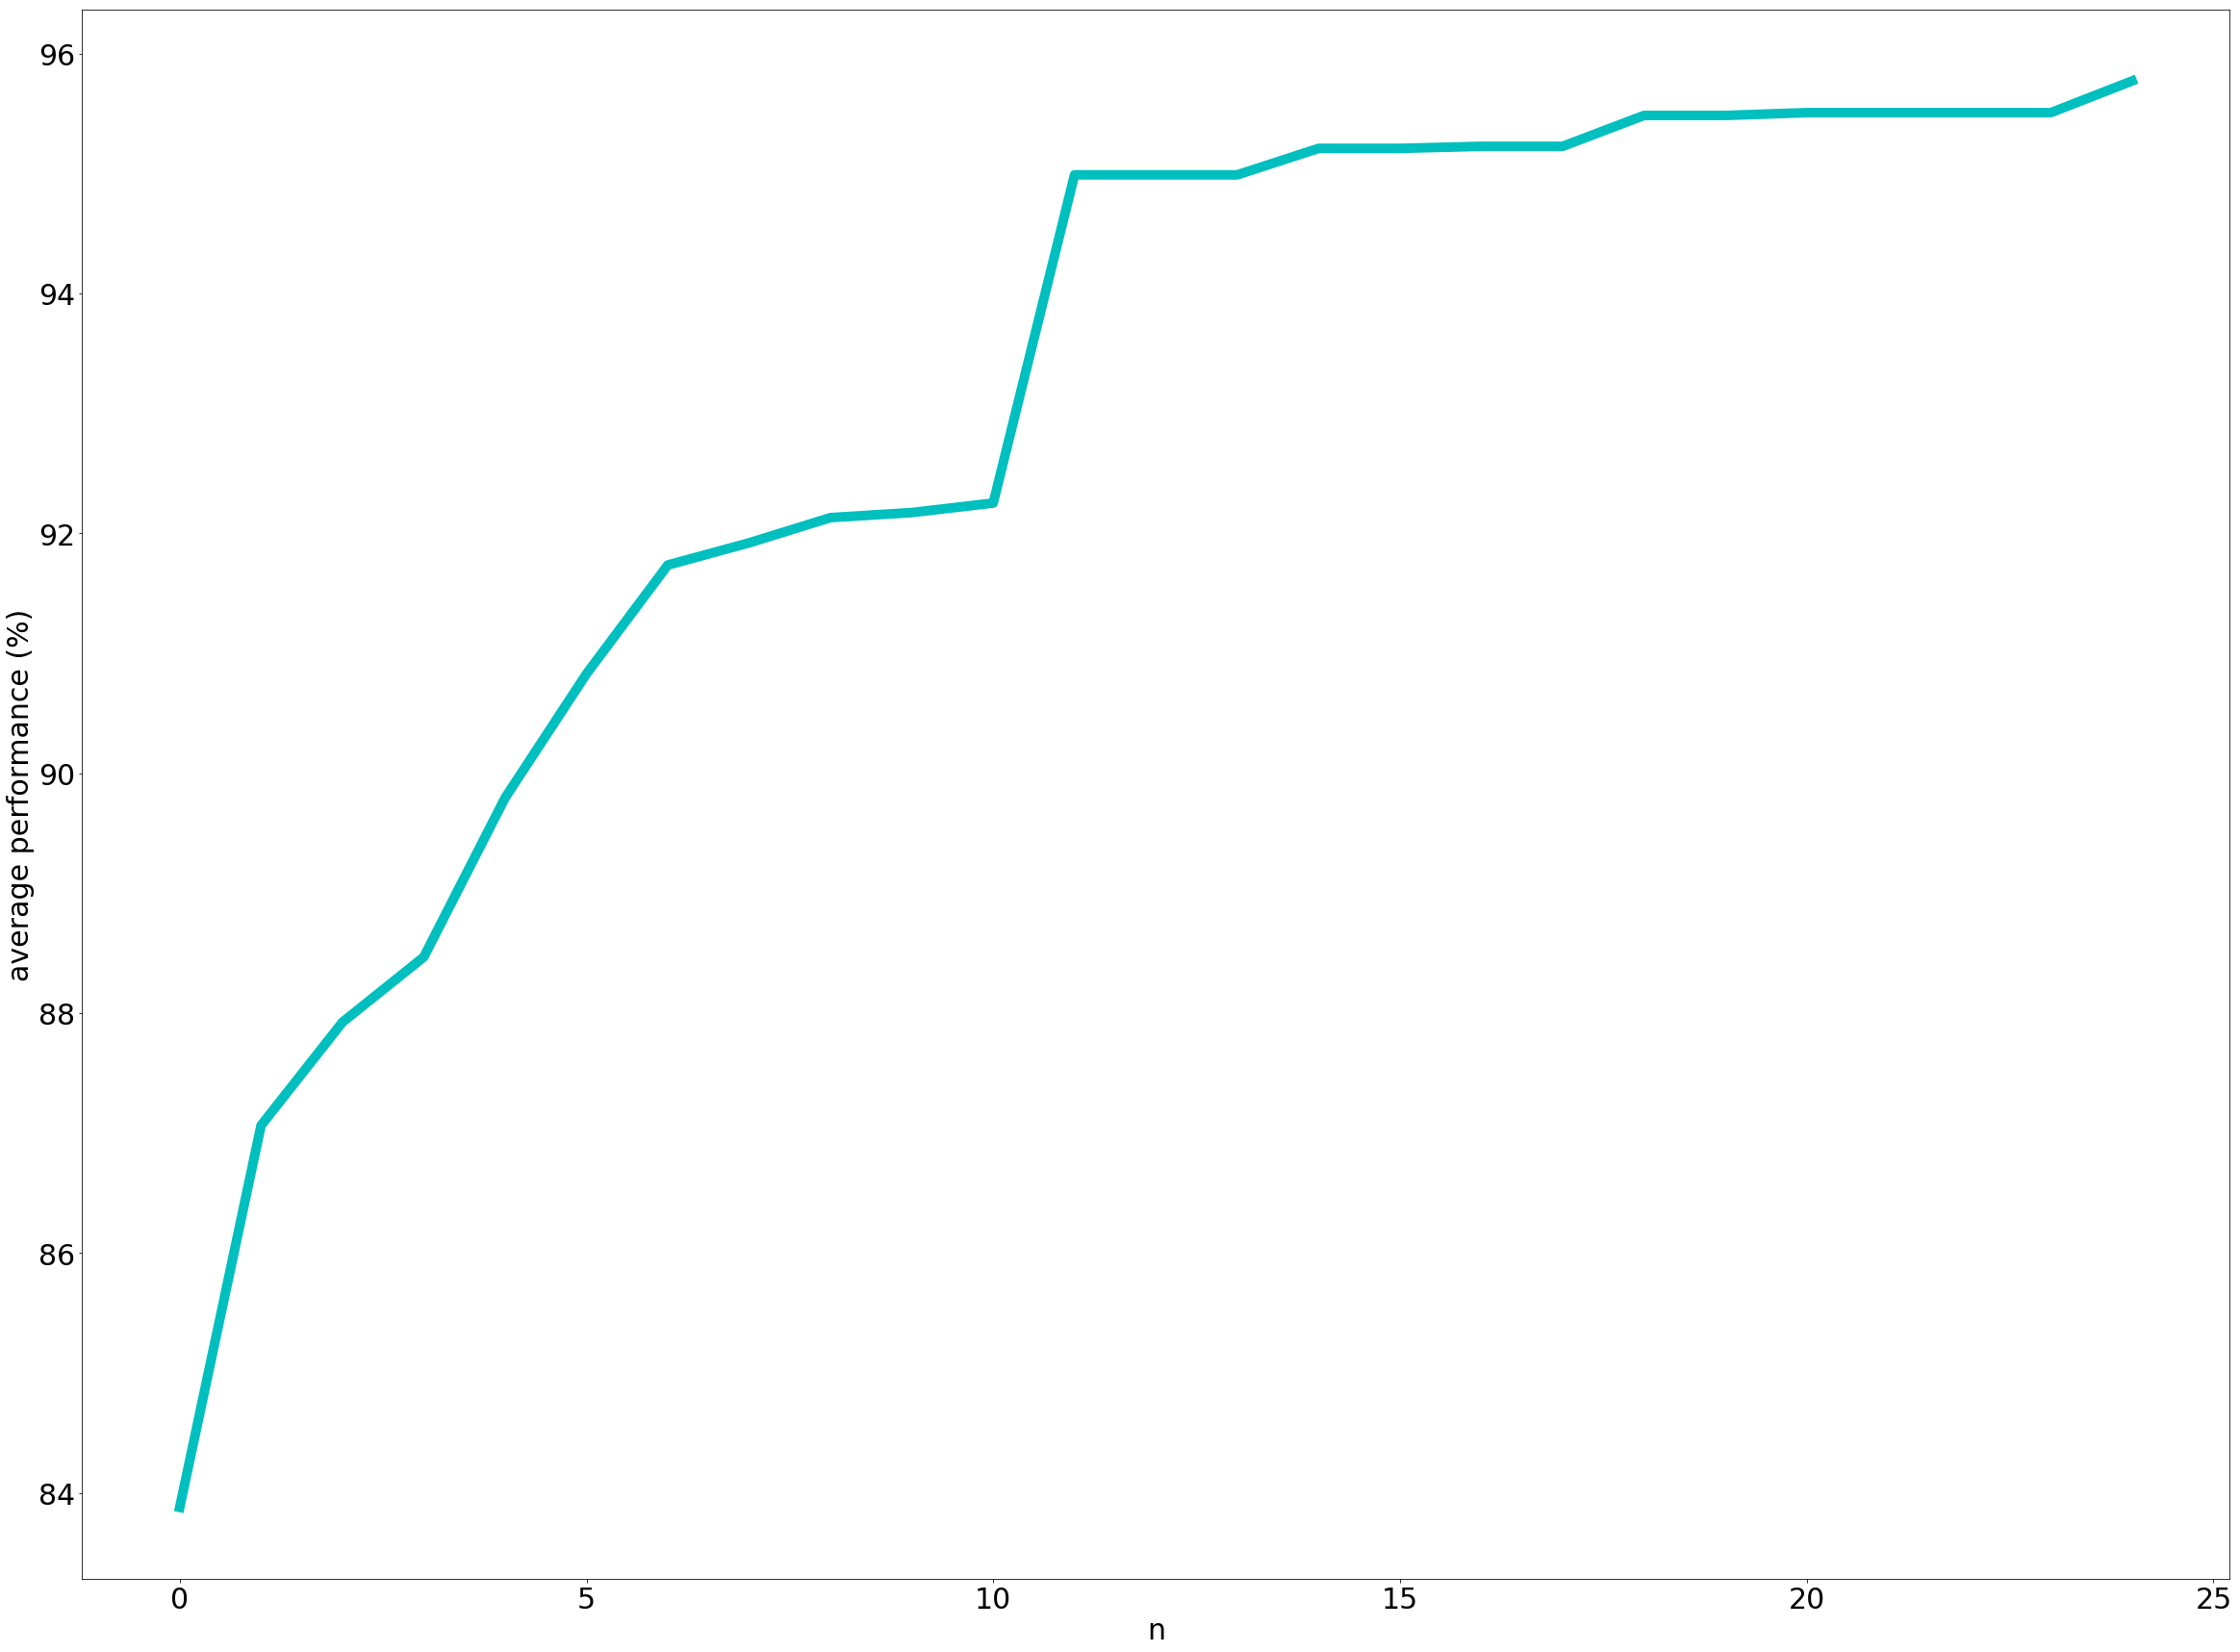

In [40]:
plt.plot(range(len(perfs)), perfs, 'c-', linewidth=10)

plt.ylabel('average performance (%)', fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('n', fontsize=30)
plt.xticks(fontsize=30)
